In [6]:
import torch
from pathlib import Path
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [4]:
names = Path("../names.txt").read_text().split("\n")
num_names = len(names)
print(f"There are {num_names} names in the dataset")
print(f"First 10 are:\n{names[:10]}")

There are 32033 names in the dataset
First 10 are:
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [3]:
tokenizer = {s:i for (i,s) in enumerate(".abcdefghijklmnopqrstuvwxyz")}
print(tokenizer)
detokenizer = {i:s for (s,i) in tokenizer.items()}
print(detokenizer)

{'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [204]:
def build_split(fro: int, to: int):
    X = []
    Y = []
    for name in names[fro:to]:
        name = "...." + name + "."
        for chars in zip(name, name[1:], name[2:], name[3:], name[4:]):
            indeces = [tokenizer[chr] for chr in chars]
            X.append(indeces[:4])
            Y.append(indeces[4])
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

xtr, ytr = build_split(0, num_names//100*90)
print(f"xtr: {xtr.shape}")
print(f"ytr: {ytr.shape}")
xdev, ydev = build_split(num_names//100*90, num_names)
print(f"xdev : {xdev.shape}")
print(f"ydev: {ydev.shape}")

xtr: torch.Size([205209, 4])
ytr: torch.Size([205209])
xdev : torch.Size([22937, 4])
ydev: torch.Size([22937])


In [336]:
class FlattenConsecutive(torch.nn.Module):
    def __init__(self):
        super(FlattenConsecutive, self).__init__()
        self._parameters = {}
        self._modules = {}
        self.out = None

    def forward(self, x):
        B, C, E = x.shape
        self.out = x.view(B, C//2, E*2)
        if self.out.shape[1] == 1:
            self.out = torch.squeeze(self.out, dim=1)
        return self.out

In [344]:
embedding_size = 5
vocab_size = len(tokenizer)
block_size = 4
hidden_size = 200
emb = torch.nn.Embedding(vocab_size, embedding_size)
flat1 = FlattenConsecutive()
lin1 = torch.nn.Linear(2*embedding_size, hidden_size)
tanh = torch.nn.Tanh()
flat2 = FlattenConsecutive()
lin2 = torch.nn.Linear(2*hidden_size, vocab_size)
model = torch.nn.Sequential(emb, flat1, lin1, tanh, flat2, lin2)
for parameter in model.parameters():
    parameter.requires_grad = True

In [345]:
num_params = 0
for parameter in model.parameters():
    num_params += parameter.nelement()
num_params
losses = []
batch_size = 64

In [356]:
for _ in range(100000):
    indices = torch.randint(low=0, high=xtr.shape[0], size=(batch_size,))
    xbatch = xtr[indices]
    ybatch = ytr[indices]
    logits = model(xbatch)
    loss = F.cross_entropy(logits, ybatch)
    loss.backward()
    for param in model.parameters():
        param.data += -0.01 * param.grad
        param.grad = None
    losses.append(loss.item())
print(loss.item())

2.051250696182251


In [324]:
for layer in model:
    if hasattr(layer, "out"):
        print(f"{layer} -> {layer.out.shape}")

FlattenConsecutive() -> torch.Size([64, 2, 10])
FlattenConsecutive() -> torch.Size([64, 1, 400])


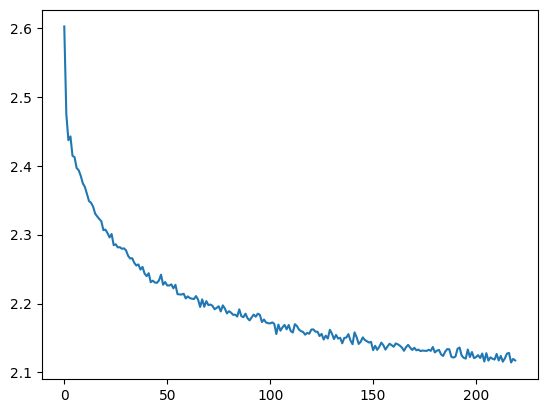

In [357]:
plot_losses = torch.tensor(losses)
plot_losses = plot_losses.view(-1, 1000)
plot_losses = plot_losses.mean(dim=1)
plt.plot(plot_losses)

In [358]:
for _ in range(10):
    sampled = None
    name = "...."
    while sampled != ".":
        idxs = [tokenizer[chr] for chr in name[-4:]]
        context = torch.tensor([idxs])
        logits = model(context)
        P = logits.softmax(1)
        idx = torch.multinomial(P, 1)
        sampled = detokenizer[idx.item()]
        name += sampled
    print(f"{name[4:-1]}")

kori
iseawni
loulleni
michaly
arcisc
shigh
gerslepe
anillee
talouharemisra
anne


In [359]:
logits = model(xtr)
training_loss = F.cross_entropy(logits, ytr)
print(f"Training loss: {training_loss.item()}")

logits = model(xdev)
dev_loss = F.cross_entropy(logits, ydev)
print(f"Dev loss: {dev_loss.item()}")

Training loss: 2.1184051036834717
Dev loss: 2.3338162899017334
